In [27]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt

import datetime as dt
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten,Reshape, LeakyReLU, BatchNormalization, UpSampling2D, Conv2D, Embedding, Concatenate, Multiply, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

devices = tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(devices[0], 'GPU')

def bulid_generator(latent_dim, class_num, img_shape):

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(class_num,), dtype='float32')
    
#     model_input = noise
    model_input = Concatenate()([noise, label])

    size = img_shape[0] // 4

    # 入力ノイズ: 100 --> FC 層の出力:(128*8*8) --> 
    #リシェイプ:(8, 8, 128) --> アップサンプリング:(16, 16, 64)
    hid = Dense(128 * size * size, activation="relu")(model_input)
    hid = Reshape((size, size, 128))(hid)
    hid = UpSampling2D()(hid)
    
    # 入力:(16, 16, 128) --> 出力:(32, 32, 128)
    hid = Conv2D(128, kernel_size=3, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = Activation("relu")(hid)
    hid = UpSampling2D()(hid)

    # 入力:(32, 32, 128) --> 出力:(32, 32, 64)
    hid = Conv2D(64, kernel_size=3, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = Activation("relu")(hid)

    # 入力:(32, 32, 64) --> 出力:(32, 32, 3)
    hid = Conv2D(img_shape[2], kernel_size=3, padding="same")(hid)
    img = Activation("tanh")(hid)

    return Model([noise, label], img)

def build_discriminator(img_shape):
    img = Input(shape=img_shape)
    label = Input(shape=(class_num,), dtype='float32')
    
# 入力:(32, 32, 3) --> 出力:(16, 16, 32)
    hid = Conv2D(32, kernel_size=3, strides=2, padding="same")(img)
    hid = LeakyReLU(alpha=0.2)(hid)

# 入力:(16, 16, 32) --> 出力:(8, 8, 64)
    hid = Conv2D(64, kernel_size=3, strides=2, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

# 入力:(8, 8, 64) --> 出力:(4, 4, 128)
    hid = Conv2D(128, kernel_size=3, strides=2, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)

# 入力:(4, 4, 128) --> Conv 出力:(4, 4, 256) --> falatten:(4096(4*4*256))
    hid = Conv2D(256, kernel_size=3, strides=2, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = Flatten()(hid)

    # 入力:(4096), (10) --> マージ (4106)
    merge = Concatenate()([hid, label])
#     merge = hid

# 入力:(4106) --> 出力:(1) 真偽の判定結果
    hid = Dense(512, activation="relu")(merge)
    validity = Dense(1, activation="sigmoid")(hid)

    return Model([img, label], validity)

def label2onehot(labels, class_num):
    return np.identity(class_num)[labels.reshape(labels.shape[0])]

def train(train_data, train_labels):
    # Rescale -1 to 1
    # 画像の輝度値を 0 -- 255 から -1 -- 1 にリサイズ
    train_data = train_data.astype(np.float32) / 127.5 - 1.0
    print(train_data.shape, train_label.shape)

    generator = bulid_generator(latent_dim, class_num, train_data.shape[1:])
    discriminator = build_discriminator(train_data.shape[1:])

    optimizer = Adam(0.0002, 0.5)

    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # The generator takes noise as input and generates imgs
    # G は入力としてノイズを受け取り画像を生成
    z = Input(shape=(latent_dim,))
    label = Input(shape=(class_num,))
    img = generator([z, label])

    # For the combined model we will only train the generator
    # コンバインドモデルは G のみ訓練するため、D の重みを固定
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    # D は入力として生成画像を受け取り、真偽を判定
    valid = discriminator([img, label])

    # The combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    # G は D を騙すように訓練される
    combined = Model([z, label], valid)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    gif_noise = np.random.normal(0, 1, (class_num, latent_dim))
    gif_labels = np.identity(class_num)
    stack_gif_img = []

    iterations = train_data.shape[0] / batch_size
    print('iterations:', iterations)

    
    # 　画像の真偽ラベルを用意
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        for i in range(int(iterations)-1):

            # ---------------------
            #  Train Discriminator
            # ---------------------
                
            s = int(epoch * iterations) + i
            np.random.seed(s)
            idx = np.random.randint(0, train_data.shape[0], batch_size)

            # Select a random half of images
            # 訓練で使用する real 画像とその画像のクラスラベルをランダムに選び出す
            imgs = train_data[idx]
            labels = train_label[idx]

            # Sample noise and generate a batch of new images
            # サンプルノイズを用意してから、そのノイズとクラスラベルを元に G で fake 画像を生成
            np.random.seed(s)
            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            gen_imgs = generator.predict([noise, labels])
            
            d_imgs = np.concatenate([imgs, gen_imgs])
            np.random.seed(s)
            np.random.shuffle(d_imgs)
            
            d_labels = np.concatenate([labels, labels])
            np.random.seed(s)
            np.random.shuffle(d_labels)
            
            d_y = np.concatenate([real, fake])
            np.random.seed(s)
            np.random.shuffle(d_y)

            # Train the discriminator (real classified as ones and generated as zeros)
            # D を訓練（real 画像のラベルを 1、fake 画像のラベルは 0）
            d_loss = discriminator.train_on_batch([d_imgs, d_labels], d_y)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            
            # Train the generator (wants discriminator to mistake images as real)
            # G を訓練（D が G の生成画像を誤って real 1 と判定するように訓練される）
            g_loss = combined.train_on_batch([noise, labels], real)

            # If at save interval => save generated image samples
            # 生成画像を保存
            if i % 500 == 0:
                print(d_loss, g_loss)
            
                # Plot the progress
                # 訓練の途中経過を出力
                print("{}:{} [D loss: {}] [G loss: {}]".format(epoch, i, d_loss[0], g_loss))

                size = 4
#                 print('real----')
#                 print(real[:size].reshape((size, )))
#                 print(discriminator.predict([imgs, labels])[:size].reshape((size, )))
#                 print('fake----')
#                 print(fake[:size].reshape((size, )))
#                 print(discriminator.predict([gen_imgs, labels])[:size].reshape((size, )))

                noise = np.random.normal(0, 1, (size * class_num, latent_dim))
                g_labels = np.tile(np.arange(class_num), size)
                g_labels = label2onehot(g_labels, class_num)
                gen_imgs = generator.predict([noise, g_labels])

                combine_images(log_path, gen_imgs, epoch, i, iterations, size)

def combine_images(log_path, gen_imgs, epoch, idx, iterations, size):
    r = size
    c = class_num
    
    # 生成画像を0-1に再スケール
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            img = gen_imgs[cnt, :, :, :]
            axs[i, j].imshow(img, cmap='gray' if img.shape[2] == 1 else 'viridis')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("{}/{}_{}.png".format(log_path, epoch, idx))
    plt.show()
    plt.close()

In [16]:
import gc
gc.collect()

102974

In [14]:
class_num = 10

(train_data, train_label), (_, _) = mnist.load_data() # X_train:(50,000 ,32, 32, 3), X_test:(10,000, 32, 32, 3)
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], train_data.shape[2], 1))
train_label = label2onehot(train_label, class_num)

(60000, 28, 28, 1) (60000, 10)
iterations: 60.0
[0.50571608543396, 0.5130000114440918] 0.6540430784225464
0:0 [D loss: 0.50571608543396] [G loss: 0.6540430784225464]


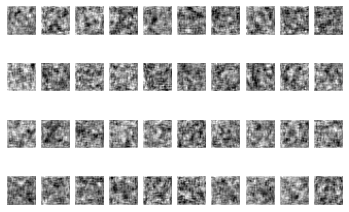

[0.4558925926685333, 0.7919999957084656] 1.4158544540405273
1:0 [D loss: 0.4558925926685333] [G loss: 1.4158544540405273]


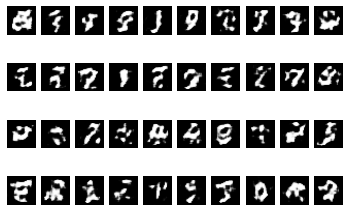

[0.3430519998073578, 0.8634999990463257] 1.4465159177780151
2:0 [D loss: 0.3430519998073578] [G loss: 1.4465159177780151]


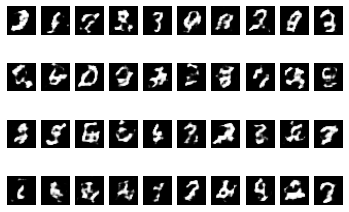

[0.36404746770858765, 0.8550000190734863] 1.7911925315856934
3:0 [D loss: 0.36404746770858765] [G loss: 1.7911925315856934]


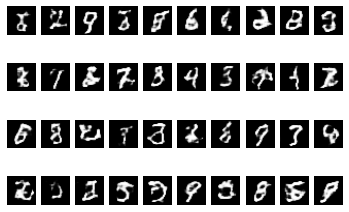

[0.3383913040161133, 0.8565000295639038] 1.318595051765442
4:0 [D loss: 0.3383913040161133] [G loss: 1.318595051765442]


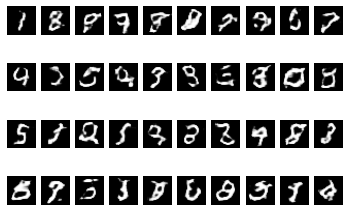

[0.3653791844844818, 0.8339999914169312] 1.121385931968689
5:0 [D loss: 0.3653791844844818] [G loss: 1.121385931968689]


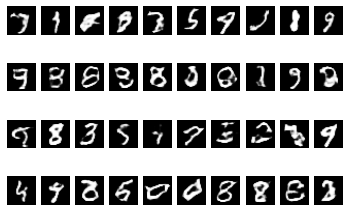

[0.36207637190818787, 0.8454999923706055] 2.480713129043579
6:0 [D loss: 0.36207637190818787] [G loss: 2.480713129043579]


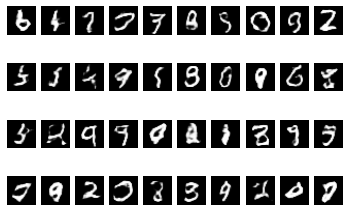

[0.32539427280426025, 0.8644999861717224] 0.9002543091773987
7:0 [D loss: 0.32539427280426025] [G loss: 0.9002543091773987]


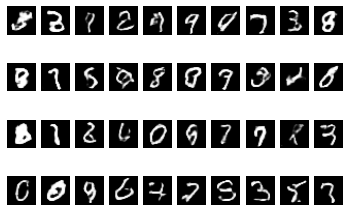

[0.4322669804096222, 0.7919999957084656] 3.9375159740448
8:0 [D loss: 0.4322669804096222] [G loss: 3.9375159740448]


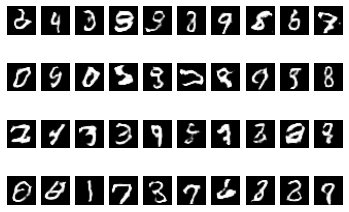

[0.3430335521697998, 0.8579999804496765] 3.116669178009033
9:0 [D loss: 0.3430335521697998] [G loss: 3.116669178009033]


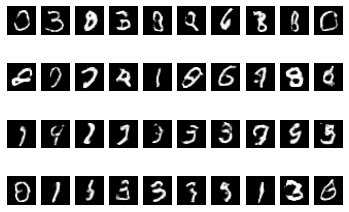

[0.3094945549964905, 0.8865000009536743] 2.4338808059692383
10:0 [D loss: 0.3094945549964905] [G loss: 2.4338808059692383]


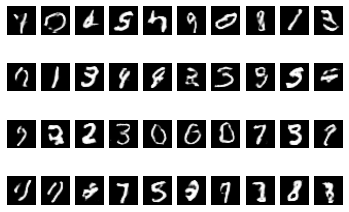

[0.33078980445861816, 0.8690000176429749] 1.3501783609390259
11:0 [D loss: 0.33078980445861816] [G loss: 1.3501783609390259]


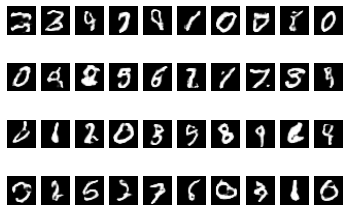

[0.29278042912483215, 0.8899999856948853] 1.859635829925537
12:0 [D loss: 0.29278042912483215] [G loss: 1.859635829925537]


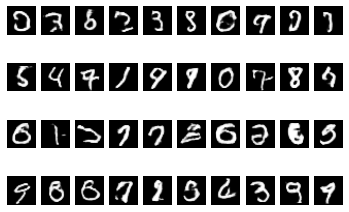

[0.3152517080307007, 0.8700000047683716] 5.275248050689697
13:0 [D loss: 0.3152517080307007] [G loss: 5.275248050689697]


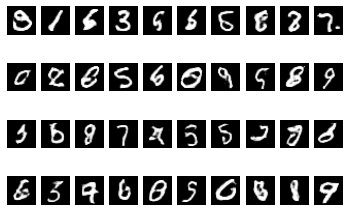

[0.3257328271865845, 0.8644999861717224] 0.6616020798683167
14:0 [D loss: 0.3257328271865845] [G loss: 0.6616020798683167]


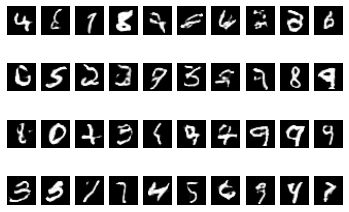

[0.3039497137069702, 0.8824999928474426] 2.7021567821502686
15:0 [D loss: 0.3039497137069702] [G loss: 2.7021567821502686]


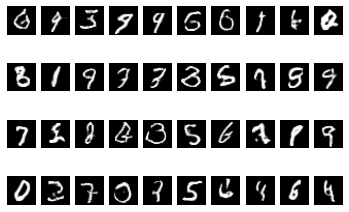

[0.37944522500038147, 0.8320000171661377] 0.5440747141838074
16:0 [D loss: 0.37944522500038147] [G loss: 0.5440747141838074]


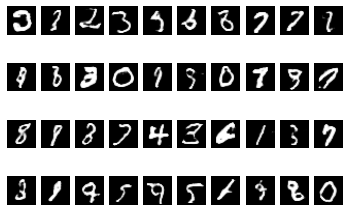

[0.2966831922531128, 0.8845000267028809] 0.45969313383102417
17:0 [D loss: 0.2966831922531128] [G loss: 0.45969313383102417]


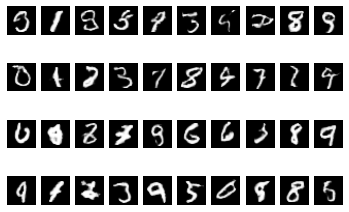

[0.3472675681114197, 0.843999981880188] 1.3611602783203125
18:0 [D loss: 0.3472675681114197] [G loss: 1.3611602783203125]


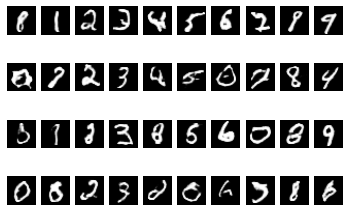

[0.3657318949699402, 0.840499997138977] 6.0712690353393555
19:0 [D loss: 0.3657318949699402] [G loss: 6.0712690353393555]


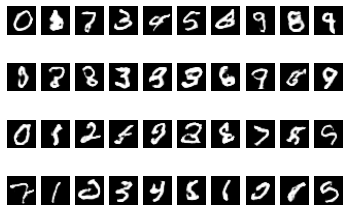

[0.43161261081695557, 0.796500027179718] 0.7308343052864075
20:0 [D loss: 0.43161261081695557] [G loss: 0.7308343052864075]


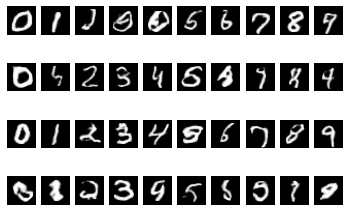

[0.44086745381355286, 0.784500002861023] 2.1074717044830322
21:0 [D loss: 0.44086745381355286] [G loss: 2.1074717044830322]


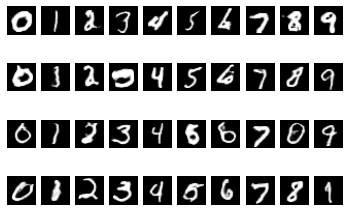

[0.37482959032058716, 0.8314999938011169] 0.996534526348114
22:0 [D loss: 0.37482959032058716] [G loss: 0.996534526348114]


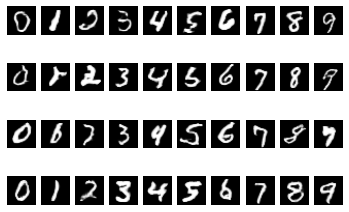

[0.3165524899959564, 0.8694999814033508] 0.13793890178203583
23:0 [D loss: 0.3165524899959564] [G loss: 0.13793890178203583]


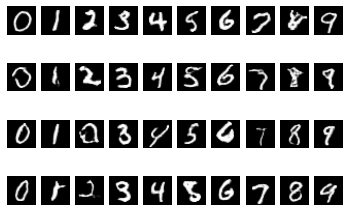

[0.3598000407218933, 0.8445000052452087] 0.34727850556373596
24:0 [D loss: 0.3598000407218933] [G loss: 0.34727850556373596]


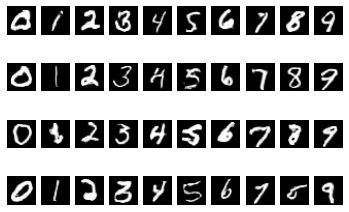

[0.3538779318332672, 0.8385000228881836] 6.4726738929748535
25:0 [D loss: 0.3538779318332672] [G loss: 6.4726738929748535]


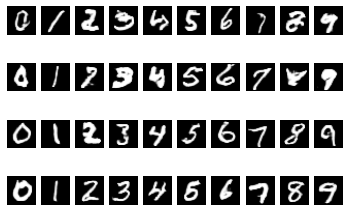

[0.3707462251186371, 0.8264999985694885] 1.4048190116882324
26:0 [D loss: 0.3707462251186371] [G loss: 1.4048190116882324]


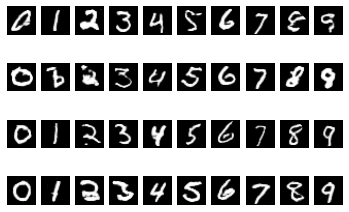

[0.3986010253429413, 0.8115000128746033] 1.645609736442566
27:0 [D loss: 0.3986010253429413] [G loss: 1.645609736442566]


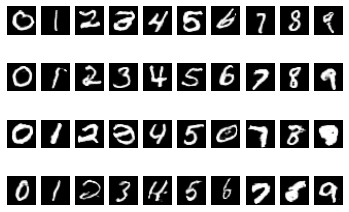

[0.4285762906074524, 0.8019999861717224] 8.32358169555664
28:0 [D loss: 0.4285762906074524] [G loss: 8.32358169555664]


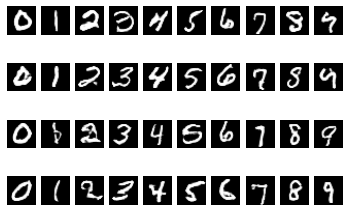

[0.4620859622955322, 0.7904999852180481] 0.7477374076843262
29:0 [D loss: 0.4620859622955322] [G loss: 0.7477374076843262]


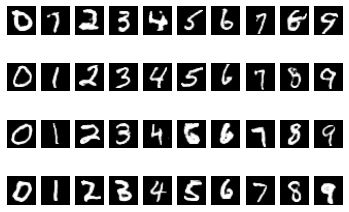

[0.38276538252830505, 0.8305000066757202] 2.2193641662597656
30:0 [D loss: 0.38276538252830505] [G loss: 2.2193641662597656]


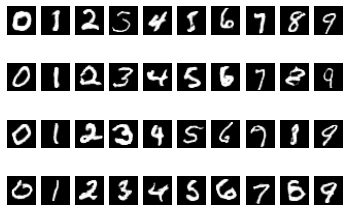

[0.41398224234580994, 0.8044999837875366] 1.8420979976654053
31:0 [D loss: 0.41398224234580994] [G loss: 1.8420979976654053]


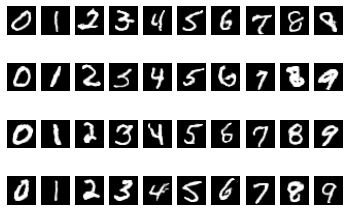

[0.390412300825119, 0.8240000009536743] 2.9187424182891846
32:0 [D loss: 0.390412300825119] [G loss: 2.9187424182891846]


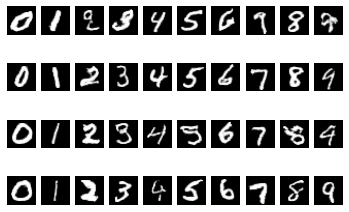

[0.3822513222694397, 0.8314999938011169] 12.14404296875
33:0 [D loss: 0.3822513222694397] [G loss: 12.14404296875]


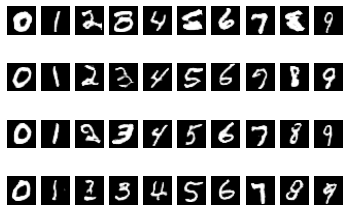

[0.3949596583843231, 0.8240000009536743] 9.891758918762207
34:0 [D loss: 0.3949596583843231] [G loss: 9.891758918762207]


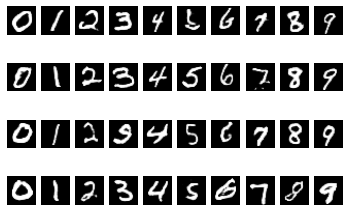

[0.25949445366859436, 0.8924999833106995] 0.10180029273033142
35:0 [D loss: 0.25949445366859436] [G loss: 0.10180029273033142]


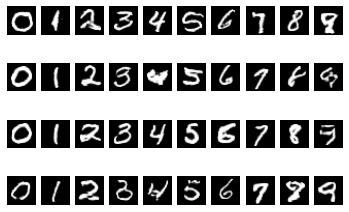

[0.28362756967544556, 0.8895000219345093] 0.008025060407817364
36:0 [D loss: 0.28362756967544556] [G loss: 0.008025060407817364]


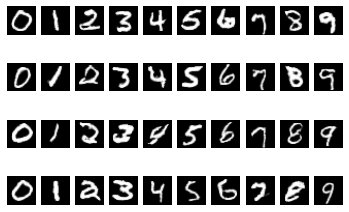

[0.3678719997406006, 0.8395000100135803] 0.0042641316540539265
37:0 [D loss: 0.3678719997406006] [G loss: 0.0042641316540539265]


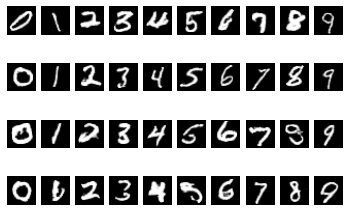

[0.4072556793689728, 0.8015000224113464] 0.9845437407493591
38:0 [D loss: 0.4072556793689728] [G loss: 0.9845437407493591]


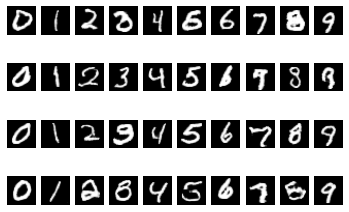

[0.411531001329422, 0.8034999966621399] 9.392090797424316
39:0 [D loss: 0.411531001329422] [G loss: 9.392090797424316]


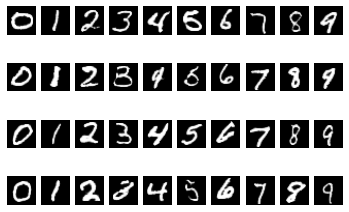

[0.33312714099884033, 0.8619999885559082] 10.629297256469727
40:0 [D loss: 0.33312714099884033] [G loss: 10.629297256469727]


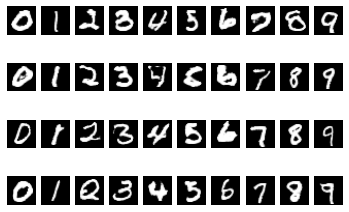

[0.3784429132938385, 0.8295000195503235] 0.02755645662546158
41:0 [D loss: 0.3784429132938385] [G loss: 0.02755645662546158]


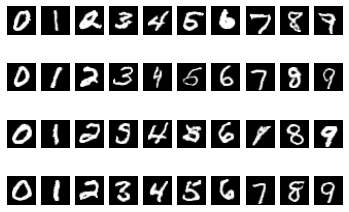

[0.38461780548095703, 0.8364999890327454] 7.193521499633789
42:0 [D loss: 0.38461780548095703] [G loss: 7.193521499633789]


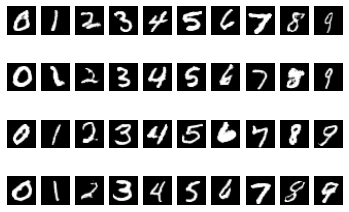

[0.4313643276691437, 0.7979999780654907] 2.2194931507110596
43:0 [D loss: 0.4313643276691437] [G loss: 2.2194931507110596]


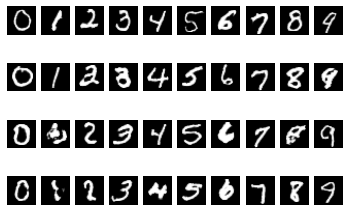

[0.3697649836540222, 0.843500018119812] 0.6300244927406311
44:0 [D loss: 0.3697649836540222] [G loss: 0.6300244927406311]


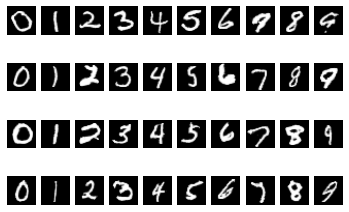

[0.40641677379608154, 0.8105000257492065] 1.9821298122406006
45:0 [D loss: 0.40641677379608154] [G loss: 1.9821298122406006]


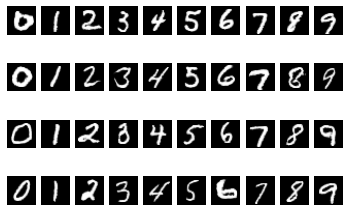

[0.4180847704410553, 0.8115000128746033] 2.2841713428497314
46:0 [D loss: 0.4180847704410553] [G loss: 2.2841713428497314]


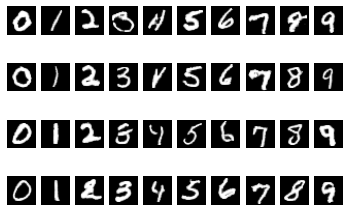

[0.43016308546066284, 0.7870000004768372] 6.268783092498779
47:0 [D loss: 0.43016308546066284] [G loss: 6.268783092498779]


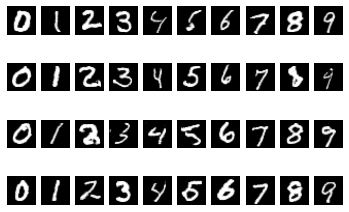

[0.4566114544868469, 0.7770000100135803] 0.41328322887420654
48:0 [D loss: 0.4566114544868469] [G loss: 0.41328322887420654]


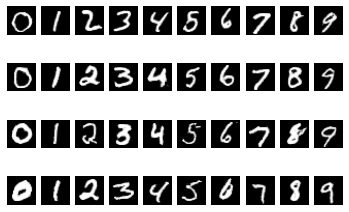

[0.44501030445098877, 0.8034999966621399] 3.3126864433288574
49:0 [D loss: 0.44501030445098877] [G loss: 3.3126864433288574]


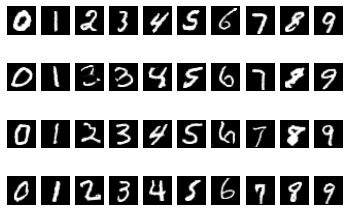

[0.43919193744659424, 0.7994999885559082] 8.757853507995605
50:0 [D loss: 0.43919193744659424] [G loss: 8.757853507995605]


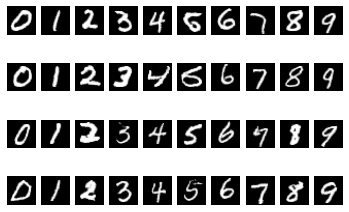

[0.4724924564361572, 0.7555000185966492] 5.465710163116455
51:0 [D loss: 0.4724924564361572] [G loss: 5.465710163116455]


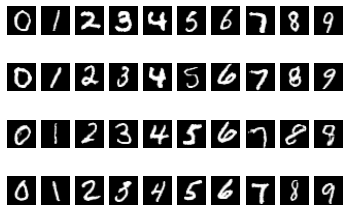

[0.41691648960113525, 0.8090000152587891] 1.2394888401031494
52:0 [D loss: 0.41691648960113525] [G loss: 1.2394888401031494]


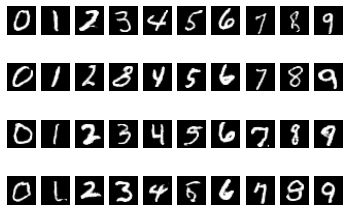

[0.4135729670524597, 0.8090000152587891] 1.5099666118621826
53:0 [D loss: 0.4135729670524597] [G loss: 1.5099666118621826]


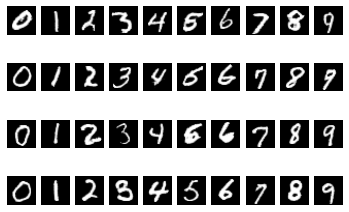

[0.4286808371543884, 0.7929999828338623] 0.27972912788391113
54:0 [D loss: 0.4286808371543884] [G loss: 0.27972912788391113]


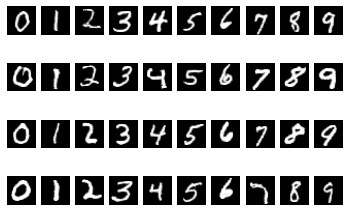

[0.4121411144733429, 0.8059999942779541] 4.758269309997559
55:0 [D loss: 0.4121411144733429] [G loss: 4.758269309997559]


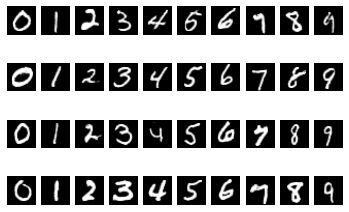

[0.4301639199256897, 0.8019999861717224] 1.1686699390411377
56:0 [D loss: 0.4301639199256897] [G loss: 1.1686699390411377]


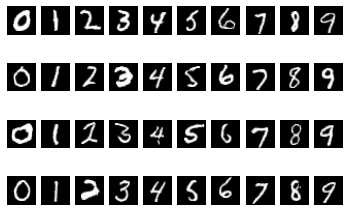

[0.42124634981155396, 0.8040000200271606] 0.20097796618938446
57:0 [D loss: 0.42124634981155396] [G loss: 0.20097796618938446]


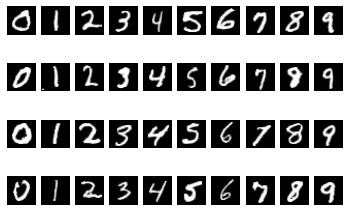

[0.4134006202220917, 0.8180000185966492] 4.95792293548584
58:0 [D loss: 0.4134006202220917] [G loss: 4.95792293548584]


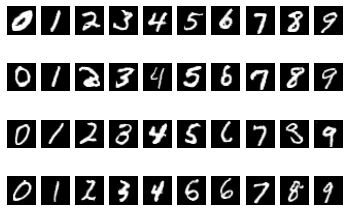

[0.4310450553894043, 0.7919999957084656] 0.5817084908485413
59:0 [D loss: 0.4310450553894043] [G loss: 0.5817084908485413]


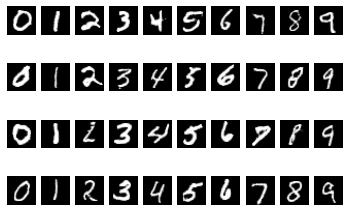

[0.413689523935318, 0.8169999718666077] 4.748440742492676
60:0 [D loss: 0.413689523935318] [G loss: 4.748440742492676]


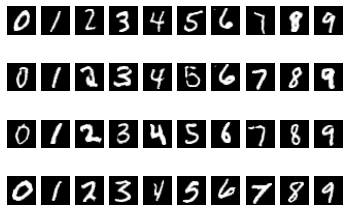

[0.4760269224643707, 0.7605000138282776] 0.007923834025859833
61:0 [D loss: 0.4760269224643707] [G loss: 0.007923834025859833]


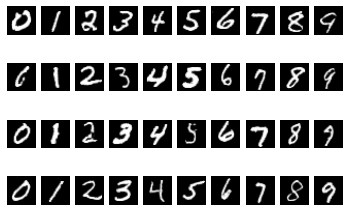

[0.41724079847335815, 0.8149999976158142] 3.6980156898498535
62:0 [D loss: 0.41724079847335815] [G loss: 3.6980156898498535]


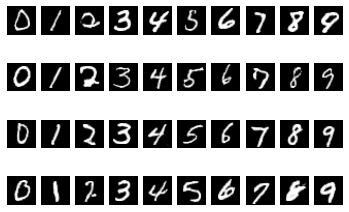

[0.4218004047870636, 0.7979999780654907] 1.1211464405059814
63:0 [D loss: 0.4218004047870636] [G loss: 1.1211464405059814]


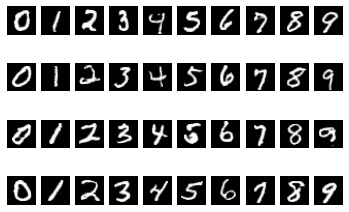

[0.4096050560474396, 0.7914999723434448] 1.2461347579956055
64:0 [D loss: 0.4096050560474396] [G loss: 1.2461347579956055]


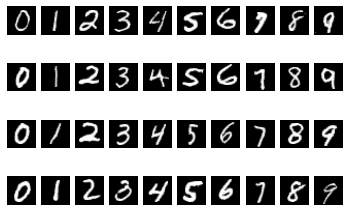

[0.4223315417766571, 0.800000011920929] 6.170097827911377
65:0 [D loss: 0.4223315417766571] [G loss: 6.170097827911377]


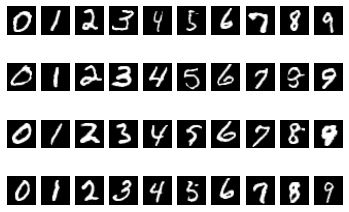

[0.413418710231781, 0.8134999871253967] 5.518579959869385
66:0 [D loss: 0.413418710231781] [G loss: 5.518579959869385]


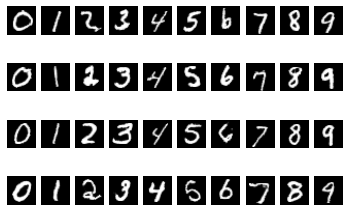

[0.4151691496372223, 0.8149999976158142] 0.3152351677417755
67:0 [D loss: 0.4151691496372223] [G loss: 0.3152351677417755]


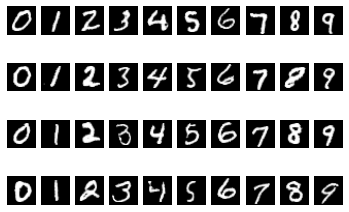

[0.41045650839805603, 0.809499979019165] 2.6465487480163574
68:0 [D loss: 0.41045650839805603] [G loss: 2.6465487480163574]


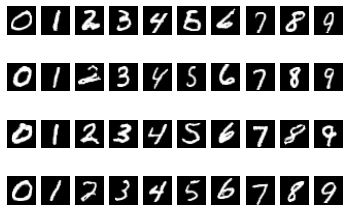

[0.405331552028656, 0.8159999847412109] 0.6312143802642822
69:0 [D loss: 0.405331552028656] [G loss: 0.6312143802642822]


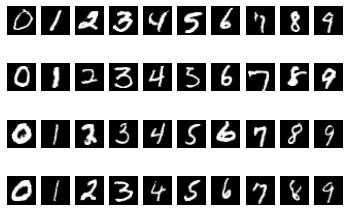

[0.40437790751457214, 0.8184999823570251] 1.7317758798599243
70:0 [D loss: 0.40437790751457214] [G loss: 1.7317758798599243]


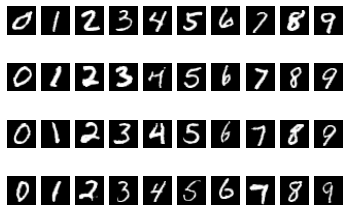

[0.39793285727500916, 0.8270000219345093] 4.929238319396973
71:0 [D loss: 0.39793285727500916] [G loss: 4.929238319396973]


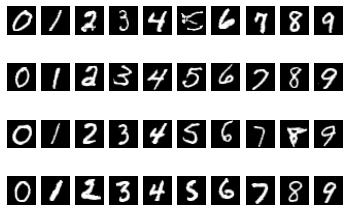

[0.41919228434562683, 0.7990000247955322] 1.148313283920288
72:0 [D loss: 0.41919228434562683] [G loss: 1.148313283920288]


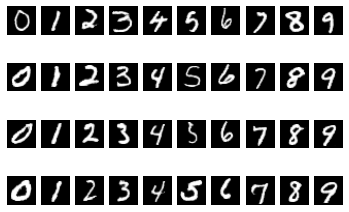

[0.4009458124637604, 0.8289999961853027] 4.137446880340576
73:0 [D loss: 0.4009458124637604] [G loss: 4.137446880340576]


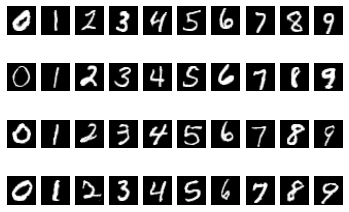

[0.4083344638347626, 0.8134999871253967] 2.876314401626587
74:0 [D loss: 0.4083344638347626] [G loss: 2.876314401626587]


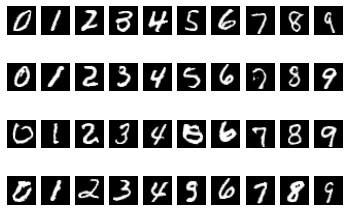

[0.3892776370048523, 0.8255000114440918] 2.472486972808838
75:0 [D loss: 0.3892776370048523] [G loss: 2.472486972808838]


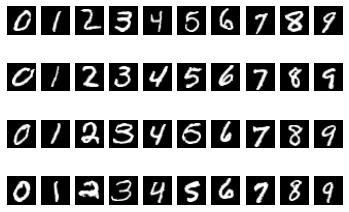

[0.40005767345428467, 0.8195000290870667] 0.7664101719856262
76:0 [D loss: 0.40005767345428467] [G loss: 0.7664101719856262]


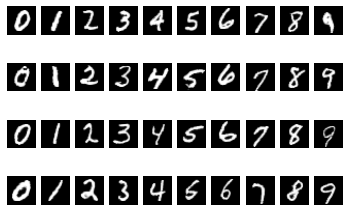

[0.380094438791275, 0.8364999890327454] 4.465811729431152
77:0 [D loss: 0.380094438791275] [G loss: 4.465811729431152]


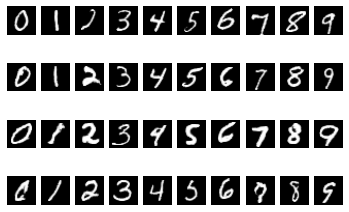

[0.3691524267196655, 0.8385000228881836] 1.0451152324676514
78:0 [D loss: 0.3691524267196655] [G loss: 1.0451152324676514]


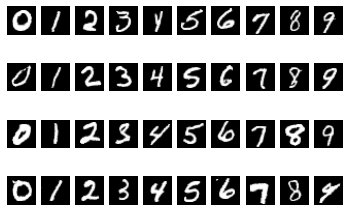

[0.3784497082233429, 0.8460000157356262] 0.5143182873725891
79:0 [D loss: 0.3784497082233429] [G loss: 0.5143182873725891]


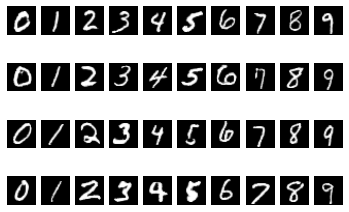

[0.37552109360694885, 0.8485000133514404] 1.6243042945861816
80:0 [D loss: 0.37552109360694885] [G loss: 1.6243042945861816]


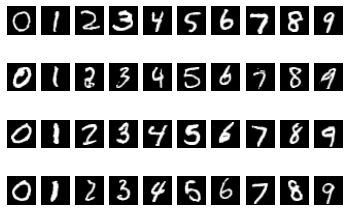

[0.41111457347869873, 0.8190000057220459] 3.805931568145752
81:0 [D loss: 0.41111457347869873] [G loss: 3.805931568145752]


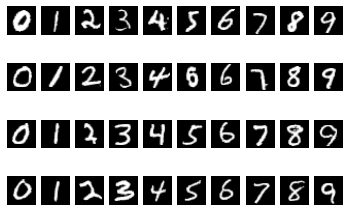

[0.37675634026527405, 0.8289999961853027] 1.7741038799285889
82:0 [D loss: 0.37675634026527405] [G loss: 1.7741038799285889]


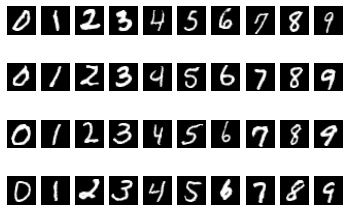

[0.4014129042625427, 0.8309999704360962] 1.139894962310791
83:0 [D loss: 0.4014129042625427] [G loss: 1.139894962310791]


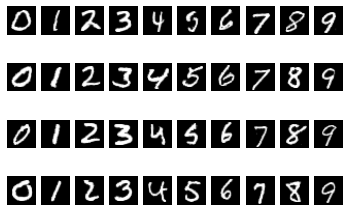

[0.3703993558883667, 0.8374999761581421] 1.4702318906784058
84:0 [D loss: 0.3703993558883667] [G loss: 1.4702318906784058]


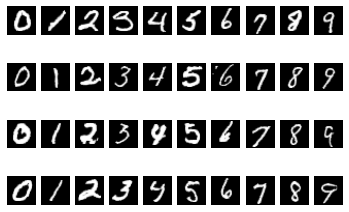

[0.3589429557323456, 0.8514999747276306] 1.269890308380127
85:0 [D loss: 0.3589429557323456] [G loss: 1.269890308380127]


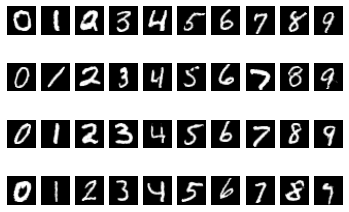

[0.3795117139816284, 0.8379999995231628] 0.7313457131385803
86:0 [D loss: 0.3795117139816284] [G loss: 0.7313457131385803]


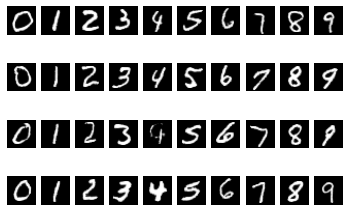

[0.36921676993370056, 0.8364999890327454] 3.27315354347229
87:0 [D loss: 0.36921676993370056] [G loss: 3.27315354347229]


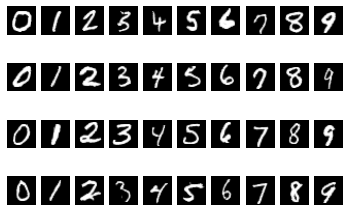

[0.38371360301971436, 0.8299999833106995] 5.064084053039551
88:0 [D loss: 0.38371360301971436] [G loss: 5.064084053039551]


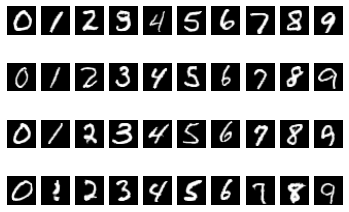

[0.3970206081867218, 0.8259999752044678] 1.1516600847244263
89:0 [D loss: 0.3970206081867218] [G loss: 1.1516600847244263]


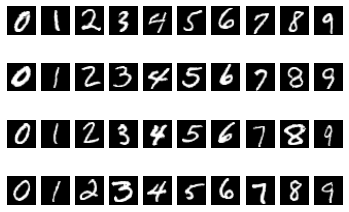

[0.4168164134025574, 0.8169999718666077] 3.1776790618896484
90:0 [D loss: 0.4168164134025574] [G loss: 3.1776790618896484]


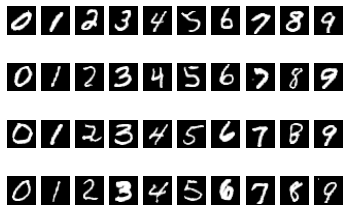

[0.356880784034729, 0.8615000247955322] 5.112673759460449
91:0 [D loss: 0.356880784034729] [G loss: 5.112673759460449]


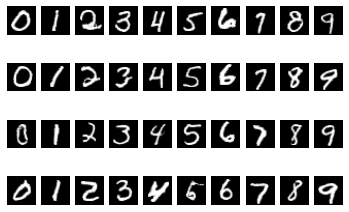

[0.3644803762435913, 0.8479999899864197] 3.040858507156372
92:0 [D loss: 0.3644803762435913] [G loss: 3.040858507156372]


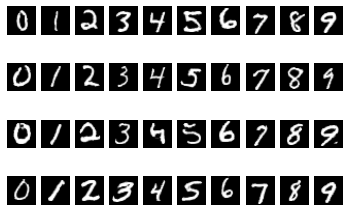

[0.33839893341064453, 0.8615000247955322] 1.818218469619751
93:0 [D loss: 0.33839893341064453] [G loss: 1.818218469619751]


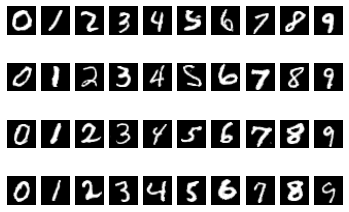

[0.3446929454803467, 0.8694999814033508] 0.40808963775634766
94:0 [D loss: 0.3446929454803467] [G loss: 0.40808963775634766]


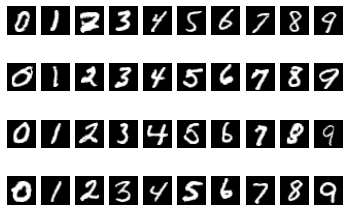

[0.3692990839481354, 0.8514999747276306] 2.0064289569854736
95:0 [D loss: 0.3692990839481354] [G loss: 2.0064289569854736]


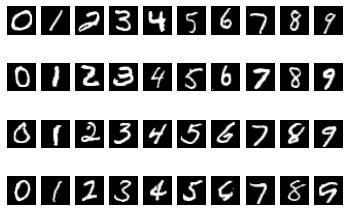

[0.35560113191604614, 0.8504999876022339] 3.7820401191711426
96:0 [D loss: 0.35560113191604614] [G loss: 3.7820401191711426]


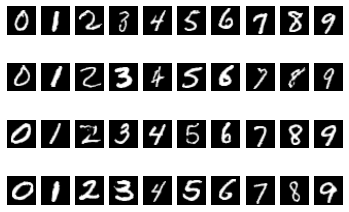

[0.35491400957107544, 0.8500000238418579] 3.1591622829437256
97:0 [D loss: 0.35491400957107544] [G loss: 3.1591622829437256]


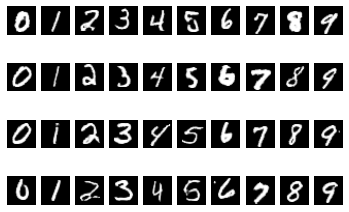

[0.3500650227069855, 0.8539999723434448] 0.042486466467380524
98:0 [D loss: 0.3500650227069855] [G loss: 0.042486466467380524]


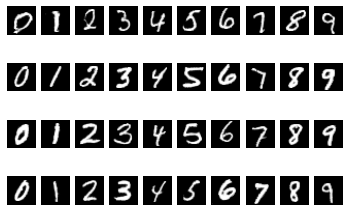

[0.3511008322238922, 0.8454999923706055] 1.0347099304199219
99:0 [D loss: 0.3511008322238922] [G loss: 1.0347099304199219]


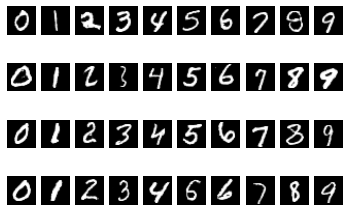

In [28]:
latent_dim = 100
batch_size = 1000
epochs = 100

log_path = 'log/{}/images'.format(dt.datetime.now().strftime("%Y-%m-%d_%H%M%S"))
os.makedirs(log_path, exist_ok=True)

train(train_data, train_label)